In [1]:
# # adapting simon's older PC-based 1dvar code to read in GMI 
# data and run oceanic retrievals. started DD 17/05/18
#   - - working as wv retrieval 03/06/18

# Set up ARTS/Python environment


In [2]:
%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/

%matplotlib inline

#import numpy as np
#import matplotlib.pyplot as plt # both set in py startup file
import glob
from h5py import File

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [3]:
from typhon.arts.workspace.variables import *

ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

In [4]:
# define absorbing species and sensor (here using metmm library, used again below)
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])
#ws.ReadXML( ws.abs_lines, "instruments/metmm/abs_lines_metmm.xml.gz")
#ws.abs_lines_per_speciesCreateFromLines()
ws.abs_lines_per_speciesSetEmpty()

# General Settings

In [5]:
ws.stokes_dim = 2 # to get V and H pol out of metmm
ws.iy_unit = "PlanckBT" # equivalent: ws.StringSet( iy_unit, "PlanckBT" )
#ws.cloudboxOff()

# Atmosphere set up # (take Psfc, T from model later)

In [6]:
ws.atmosphere_dim = 1  # for 1DVAR
#ws.VectorNLogSpace( ws.p_grid, 20, 1e5, 1e4 ) # 20 levels from 1000 to 100 hPa
p = np.array([1013.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = 0.5 * (p[1:] + p[:-1])
print(ws.p_grid.value)
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmosphereSet1D() #NEW 21/08
ws.AtmFieldsCalc()
#ws.AbsInputFromAtmFields()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]

# plot T, water vapor, N2 and O2 versus altitude
alt = np.asarray(ws.z_field).ravel() * .001 # altitude in km (for plotting)
#plt.plot(np.asarray(ws.vmr_field)[0,:,0,0], alt)
#plt.xlabel("$H_2O [mol/mol$]")
#plt.ylabel("z [km]")
#plt.plot(np.asarray(ws.vmr_field)[1,:,0,0], alt, label="$O_2$")
#plt.plot(np.asarray(ws.vmr_field)[2,:,0,0], alt, label="$N_2$")
#plt.xlabel("vmr [mol / mol]")
#plt.ylabel("z [km]")
#plt.legend()

[ 99400.  96250.  93750.  91250.  87500.  82500.  77500.  72500.  67500.
  62500.  57500.  52500.  45000.  35000.  25000.  15000.]


# Sensor definition -- GMI sensor setup w/ metmm

In [7]:
ws.ArrayOfIndexCreate("channels")
# initial sensor setup, all 13 channels at low frequency EIA
#csub = [x for x in range(13)] # 13 GMI channels total
csub = [4,11,12] # wv channels, just for testing
ws.channels = csub # 23.8 and 183 channels only for WV
ws.ArrayOfIndexCreate("viewing_angles") # necessary if just using one pencil beam angle?
ws.viewing_angles = [1] # index of viewing angles in metmm file -- for GMI, 49.2, 52.8
# current setup is low freqs at index 1, high freqs at index 0
# can these be run at same time with ARTS?

ws.sensor_pos  = np.array([[407e3]])#, -30.0, 180.0]]) # 407km alt, 30S, 180E
#can take exact alt from file if desired, same with lat/lon values (does that have effect?)
ws.sensor_time = np.array([0.0]) # same here
ws.sensor_los  = np.array([[180.0]]) # since angle taken care of in metmm file 
# zenith angle followed by azimuth. zenith=0 is straight up, 180 is straight down. azimuth=0 is N, positive to east 

ws.IndexCreate("met_mm_accuracy") 
ws.met_mm_accuracy = 1 # points within each bandwidth to comute abs characteristics

# initial exection of metmm control files
ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_gmi.arts") #atms.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
#ws.execute_controlfile("instruments/metmm/common_metmm.arts")

# Perform some checks

In [8]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
#ws.abs_lookupSetup() # not currently using lookup tables (on the fly instead)
#ws.abs_lookupCalc()

# Surface 


In [9]:
#ws.surface_scalar_reflectivity = np.array([0.5]) # nominal albedo for surface
ws.NumericCreate("wind_speed")
ws.NumericCreate("wind_direction")
ws.VectorCreate("transmittance")
#ws.NumericSet(ws.surface_skin_t, np.array([300]))
ws.transmittance  = np.ones(ws.f_grid.value.shape) # or ones, or something else?
ws.wind_speed = 8.5
ws.surface_skin_t = 290.0
#ws.wind_direction = 0.0 # can adjust based on analysis data later  -- default should be 0
# -- need sensor azimuth angle, and spacecraft heading, as arts azimuth is relative to N
#ws.salinity = .035 # default is .035 anyway
#ws.rte_pos = np.array([1])
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
ws.jacobianOff()  # turn jacobian off here???
ws.cloudboxOff()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()

# define agendas

In [10]:
from typhon.arts.workspace import arts_agenda

@arts_agenda
def surface_fastem(ws):
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceFastem(wind_speed     = ws.wind_speed,
                     wind_direction = ws.wind_direction,
                     transmittance  = ws.transmittance)
    
    
ws.TessemNNReadAscii(tessem_netv, "testdata/tessem_sav_net_V.txt")
ws.TessemNNReadAscii(tessem_neth, "testdata/tessem_sav_net_H.txt") 
@arts_agenda
def surface_tessem(ws):
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceTessem(wind_speed     = ws.wind_speed)

# set surface agenda here:
#ws.Copy(ws.surface_rtprop_agenda, surface_fastem) # choose which emis. model to run here!
ws.Copy(ws.surface_rtprop_agenda, surface_tessem) # choose which emis. model to run here!

# Call forward model

In [11]:
#
ws.yCalc()
print('Selected GMI channels, one angle:')
#print('All GMI channels, one angle:')
print(ws.y.value)
print(ws.f_grid.value.shape)
#
#ws.viewing_angles = [1] # index of viewing angles in metmm file
#csub = [4] #0,1,2,3,4,5,6,7,8] # channel subset of GMI indices
#ws.channels = csub #[0,1,2,3,4,5,6,7,8,9,10,11,12] # channel index values given in metmm sensor description
## re-exection of metmm control files ( since channels subset and angle have changed)
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_gmi.arts") 
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
#ws.transmittance  = np.ones(ws.f_grid.value.shape) # or ones, or something else?
#ws.yCalc()
#
## run at other incidence angle?
#ws.viewing_angles = [0] # index of viewing angles in metmm file -- for GMI, 49.2, 52.8
#csub = [9,10,11,12] # channel subset of GMI indices
#ws.channels = csub #[0,1,2,3,4,5,6,7,8,9,10,11,12] # channel index values given in metmm sensor description
## re-exection of metmm control files ( since channels subset and angle have changed)
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_gmi.arts")
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
#ws.transmittance  = np.ones(ws.f_grid.value.shape) # or ones, or something else?
## append y values to previous y vector from yCalc above
#ws.yCalcAppend(jacobian_quantities_copy = ws.jacobian_quantities)
#
#print('All GMI channels, two angles (appended):')
#print(ws.y.value)
#

Selected GMI channels, one angle:
[ 235.05211253  257.90414452  271.69351192]
(10,)


In [12]:
# now perturb the initial VMR field for water vapor
if not "orig_h2o" in globals().keys():
    orig_h2o = np.array(ws.vmr_field)[0,:,0,0] # save original WV profile (true state)


# Set up PCs for retrieval

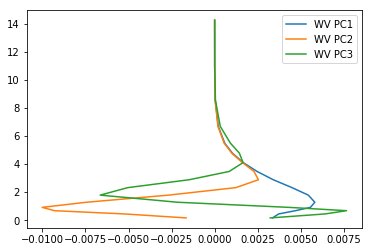

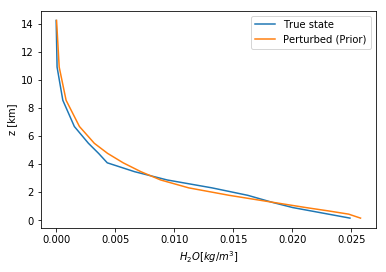

In [13]:
invar = np.loadtxt("/home/dudavid/projects/typhon_examples/pcs.txt") # read in PCs from ascii file
npc = 3

meanwv = invar[0:16][::-1] # invert profiles to fit fwd model
A = invar[16:].reshape(6,16) # first 6 PCs are included in file
factor = 28.966/18.016 * 0.001 # convert WV mixing ratio (g/kg) to vmr (mol/mol)
PCs     = np.ascontiguousarray(A[:npc,::-1] * factor)
meanwv *= factor
perturbed = meanwv # a priori state is mean profile of PCA
for i in range(npc): # plot first x PCs
    plt.plot(PCs[i,:],alt,label="WV PC"+str(i+1))
plt.legend()

plt.figure()
plt.plot(orig_h2o.ravel(), alt, label="True state")
plt.plot(perturbed, alt, label="Perturbed (Prior)")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()

# Designate surface as retrievable

In [14]:
# add surface variables

snames = ["Water skin temperature", "Wind speed", "Salinity"]
sdata = np.array([ws.t_surface.value.ravel()[0], ws.wind_speed.value, 0.035]).reshape(3,1,1)

# don't copy to arts variables yet... otherwise ycalc bombs due to SurfaceDummy
#ws.Copy(ws.surface_props_data, sdata)
#ws.Copy(ws.surface_props_names, snames)

# Set up OEM retrieval

In [15]:
ws.retrievalDefInit()
npc = 3 #+1 # trying to add surface
rvars = np.ones(npc)#*2.0 # define apriori variances of retrieved variables
#rvars[:] = [2.5,1.2,0.5, 2.5] # decreasing variability
rvars[:] = [2.5,1.2,0.5] # decreasing variability
sx_cov = np.diag(rvars) # CHANGE TO MATCH SIZE OF Xa!!
ws.covmat_sxSet(sx_cov)
print('Sx:',sx_cov)
#ws.jacobianAddSurfaceQuantity(
#    g1=ws.lat_grid, g2=ws.lon_grid,   # can use instead of retrievalAdd, init's fewer variables
#    quantity="Wind speed"
#)
#ws.jacobianAddAbsSpecies(   # can use instead of retrievalAdd, init's fewer variables
ws.retrievalAddAbsSpecies(   # only retrieval variable is abs species, water vapor
 species="H2O-PWR98",
 unit="vmr", 
 g1=ws.p_grid,
 g2=ws.lat_grid,
 g3=ws.lon_grid
)

# offset has to be a copy of meanwv, as original in memory is untransformed!
ws.jacobianSetAffineTransformation(transformation_matrix=PCs, offset_vector=np.copy(meanwv))
chan_err = 2.1 # for now all the same:
se_cov = np.diag(np.zeros(ws.y.value.size) + chan_err**2 ) # set channel assumed errors
#se_cov[4,4] = 2.5
#se_cov[11,11] = 2.0
#se_cov[12,12] = 2.0
print('Se ',se_cov)
ws.covmat_seSet(se_cov)
ws.retrievalDefClose()

ws.ArrayOfIndexCreate("viewing_angles_1")
ws.viewing_angles_1 = [1]
ws.ArrayOfIndexCreate("viewing_angles_2")
ws.viewing_angles_2 = [0]

ws.ArrayOfIndexCreate("channels_1")
ws.channels_1 = [4]
ws.ArrayOfIndexCreate("channels_2")
ws.channels_2 = [11, 12]


# define inversion iteration as function object within python
print(ws.f_grid.value.shape)
@arts_agenda
def inversion_iterate_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter) # on simon's advice
    ws.x2artsStandard()  # map x to ARTS's variables
    ws.vmr_fieldClip(species = "H2O-PWR98", limit_low = 1e-5) # arts function creates lower limit for wv
    ws.atmfields_checkedCalc()  # to be safe, rerun checks dealing with atmosph.
    ws.atmgeom_checkedCalc()
    
    # NOTE: IF WANTING TO CHANGE CHANNELS/ANGLES, NEED TO USE arts COMMANDS ONLY!
    #ws.Print(ws.y)
    
    #ws.ArrayOfIndexSet(ws.viewing_angles,[1])
    #ws.ArrayOfIndexSet(ws.channels,[4]) # run low freqs first
    ws.Copy(ws.viewing_angles, ws.viewing_angles_1)
    ws.Copy(ws.channels, ws.channels_1)
    
    #ws.Print(ws.y)
    #ws.viewing_angles = [1] # low freq channel EIA for all channels rn
    #ws.channels = [0,1,2,3,4,5,6,7,8]#,9,10,11,12] # channel index values given in metmm sensor description
    # re-exection of metmm control files ( since channels subset and angle have changed)
    INCLUDE("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
    INCLUDE("instruments/metmm/sensor_descriptions/sensor_gmi.arts") #atms.arts")
    INCLUDE("instruments/metmm/sensor_descriptions/apply_metmm.arts") # to execute CF?
    #ws.Print(ws.f_grid.value.shape)
    #ws.transmittance  = np.ones(ws.f_grid.value.shape) # or ones, or something else?
    ws.VectorSetConstant(ws.transmittance, 1, 1.0) # needed for emis model, right size
    #ws.VectorSetConstant(ws.transmittance,ws.f_grid.value.shape,1.0) # needed for emis model, right size
    ws.yCalc()  # calculate yf and jacobian matching x
    #ws.Print(ws.y)
    
    #ws.ArrayOfIndexSet(ws.viewing_angles, [0])
    #ws.ArrayOfIndexSet(ws.channels, [11,12]) # run high freqs next
    ws.Copy(ws.viewing_angles, ws.viewing_angles_2)
    ws.Copy(ws.channels, ws.channels_2)
    
    INCLUDE("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
    INCLUDE("instruments/metmm/sensor_descriptions/sensor_gmi.arts") #atms.arts")
    INCLUDE("instruments/metmm/sensor_descriptions/apply_metmm.arts") # to execute CF?
    ws.VectorSetConstant(ws.transmittance,2,1.0) # needed for emis model, right size
    #ws.VectorSetConstant(ws.transmittance,ws.f_grid.value.shape,1.0) # needed for emis model, right size
    ws.yCalcAppend(jacobian_quantities_copy = ws.jacobian_quantities)
    
    #ws.yCalc()  # calculate yf and jacobian matching x
    ws.Print(ws.jacobian,0)
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term
    #ws.jacobianAdjustAfterIteration() 
    ws.jacobianAdjustAndTransform()
    # last line takes care of some fixes needed to get the jacobian right for iterative solutions
    ws.vmr_fieldClip(species = "H2O-PWR98", limit_low = 1e-5) # arts function creates lower limit for wv
    
ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda) # copy python function to arts


Sx: [[ 2.5  0.   0. ]
 [ 0.   1.2  0. ]
 [ 0.   0.   0.5]]
Se  [[ 4.41  0.    0.  ]
 [ 0.    4.41  0.  ]
 [ 0.    0.    4.41]]
(10,)


In [16]:
ws.inversion_iterate_agenda.print()

In [17]:
# Define observation vector, prior state vector, empty vectors for y out and x out
#ws.xaStandard() # set xa to vmr field, effectively 
xa = np.zeros(npc) + .5 # if supplying user-defined a priori vector
xa[:] = [.02, 0.01, .15]
ws.Copy(ws.xa, xa)
ws.x = np.array([]) # create empty vector for retrieved state vector?
ws.yf = np.array([]) # create empty vector for simulated TB?
ws.jacobian = np.array([[]])



# Read in GMI data from L1C file

In [18]:
# Import GMI L1C file with brightness temperatures (TBs)
paf = '/home/dudavid/Dendrite/Dendrite/SatData/GMI/L1C/'
l1c = glob.glob(paf+'*.HDF5')
print(l1c[0])

for f in l1c[0:1]:
    gfi = File(f)
    tb1 = gfi['S1/Tc'][:]
    tb2 = gfi['S2/Tc'][:]
    #print(np.shape(tbs),type(tbs))
    tbs = np.append(tb1, tb2, axis=2) #gfi['S2/Tc'][:],axis=1)
    print(np.shape(tbs))
    lat = gfi['S1/Latitude'][:]
    lon = gfi['S1/Longitude'][:]
    eia = np.append(gfi['S1/incidenceAngle'][:],gfi['S2/incidenceAngle'][:],axis=2)
    #print(np.shape(eia)) # EIA is one for S1 channels, one for S2 (approx 52.8, 49.2 deg)
    # READ THESE IN BUT NOT CURRENTLY USED
    # can also import SC data, time data, etc from L1C file
    

/home/dudavid/Dendrite/Dendrite/SatData/GMI/L1C/1C-R.GPM.GMI.XCAL2016-C.20180418-S004034-E021307.023497.V05A.HDF5
(2962, 221, 13)


In [19]:
# pick a pixel and scan position to try
px, scn = 120, 2487 # set up to run in loop of pix/scans later

# ascribe GMI Tb vector to y vector
ws.Copy(ws.y, tbs[scn, px, csub]) #careful! csub set near top, has to match stuff in agenda
#ws.Copy(ws.y, np.asarray([234.2,257.3,271.4]))
print("GMI Tb vector: ")
print(ws.y.value)
#print(tbs[scn,px,csub])
print('Lat/Lon: ',lat[scn,px],lon[scn,px]) # off the coast of Sur america
before = np.copy(ws.vmr_field)[0,:,0,0]
print('WV before: ',before)

GMI Tb vector: 
[ 223.28     257.48999  269.48001]
Lat/Lon:  -25.6284 -80.4819
WV before:  [  2.48788026e-02   2.30550908e-02   2.15647025e-02   2.00340285e-02
   1.83366240e-02   1.62298995e-02   1.31906474e-02   9.39667482e-03
   6.63891341e-03   4.33126653e-03   3.59724435e-03   2.73652713e-03
   1.54492807e-03   5.68114613e-04   8.28423022e-05   5.70279862e-06]


# Run OEM retrieval

In [20]:
ws.OEM(method="lm", #lm","gn"
    max_iter=1000,
    display_progress=1,
    max_start_cost=1e5,
    lm_ga_settings=np.array([10.0,2.0,2.0,10000000000.0,1.0,99.0]))
ws.x2artsStandard() # convert from ARTS coords back to user-defined grid

ARTS[93913427150160]: 
ARTS[93913427150160]:                                 MAP Computation                                
ARTS[93913427150160]: Formulation: Standard
ARTS[93913427150160]: Method:      Levenberg-Marquardt
ARTS[93913427150160]: 
ARTS[93913427150160]:  Step     Total Cost         x-Cost         y-Cost    Conv. Crit.   Gamma Factor
ARTS[93913427150160]: --------------------------------------------------------------------------------
ARTS[93913427150160]:     0        13.3141              0        13.3141                     10.000000
ARTS[93913427150160]:     1        2.03402       0.242274        1.79175        6.19451       5.000000
ARTS[93913427150160]:     2        1.12795       0.122434        1.00551       0.922016       2.500000
ARTS[93913427150160]:     3       0.971343       0.170395       0.800947       0.130968       1.250000
ARTS[93913427150160]:     4       0.959325       0.152928       0.806396       0.035728       1.250000
ARTS[93913427150160]:     5     

In [21]:
# save resultant WV profile to 'retrieved'
retrieved = np.copy(ws.vmr_field)[0,:,0,0]
retrieved[retrieved < 0] = 1e-5 # top level might go negative??
print(retrieved)


[  2.20965754e-02   1.95726843e-02   1.55435847e-02   1.25130380e-02
   1.03202957e-02   8.47829191e-03   7.32151525e-03   6.49321389e-03
   5.66101960e-03   4.70613024e-03   3.76213687e-03   2.89432045e-03
   1.85130812e-03   8.25317905e-04   2.59885323e-04   3.87328931e-05]


# Look at results

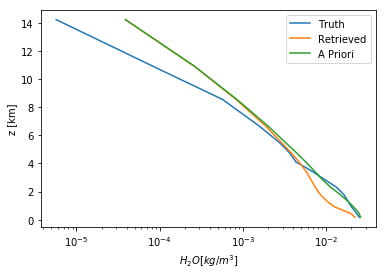

In [22]:
plt.plot(orig_h2o, alt, label="Truth")
plt.plot(retrieved, alt, label="Retrieved")
plt.plot(perturbed, alt, label="A Priori")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.xscale("log")
plt.legend()

In [23]:
# compare simulated and 'observed' TB from 
residual = ws.y.value - ws.yf.value
print(ws.y.value)
print(ws.yf.value)
print(tbs[scn,px,csub])
print('residual: ',residual) 

[ 223.28     257.48999  269.48001]
[ 223.51891891  254.66979561  270.97330244]
[ 223.27999878  257.48999023  269.48001099]
residual:  [-0.23891891  2.82019439 -1.49329244]


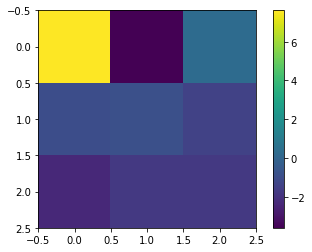

In [24]:
# plot jacobian -- should show sensitivity in middle troposphere
plt.imshow(ws.jacobian)
plt.colorbar()

1.73050968277


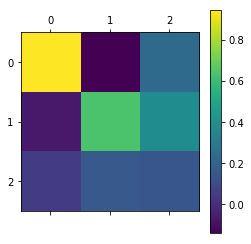

In [25]:
ws.avkCalc() # calculate averaging kernel (A-matrix)
plt.matshow(ws.avk)
plt.colorbar()
np.diag(ws.avk)
print(np.sum(np.diag(ws.avk))) # print trace of A-matrix, aka degrees of freedom for signal (DFS)

In [26]:
# calculate posterior covariance matrices of observations and a priori
ws.covmat_soCalc() # observation covariance matrix
ws.covmat_ssCalc() # smoothing covariance matrix

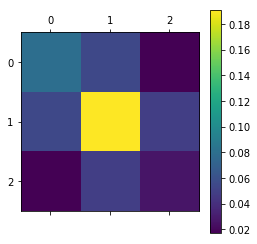

In [27]:
# plot posterior observation covariance matrix
plt.matshow(ws.covmat_so)
plt.colorbar()